# figures_draft2017b.ipynb

## Purpose
Produce figures for *"Effective radiative forcing in the aerosol-climate model CAM5.3-MARC-ARG"*, based on results from project [p17c-marc-comparison](https://github.com/grandey/p17c-marc-comparison).

## Requirements
- NetCDF files produced by [analysis_cdo_nco_draft2017b.ipynb](https://github.com/grandey/p17c-marc-comparison/blob/master/manuscript_draft2017b/analysis_cdo_nco_draft2017b.ipynb).
- Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy) ([doi:10.5281/zenodo.1053020](https://doi.org/10.5281/zenodo.1053020)).

## Author
Benjamin S. Grandey, 2017

In [1]:
! date

Mon Nov 27 14:33:07 +08 2017


In [2]:
import climapy
from glob import glob
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import pandas as pd
import scipy
from scipy import stats
import xarray as xr

# Print versions of packages
for module in [climapy, np, pd, scipy, xr]:
    try:
        print('{}.__version__ = {}'.format(module.__name__, module.__version__))
    except AttributeError:
        pass

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 40  # reduce resolution of inline figures to reduce notebook size

climapy.__version__ = 0.1.0+b35937c
numpy.__version__ = 1.13.3
pandas.__version__ = 0.21.0
scipy.__version__ = 1.0.0
xarray.__version__ = 0.10.0


## Post-processed data file location
Location of files written by [analysis_cdo_nco_draft2017b.ipynb](https://github.com/grandey/p17c-marc-comparison/blob/master/manuscript_draft2017b/analysis_cdo_nco_draft2017b.ipynb).

In [3]:
in_dir = os.path.expandvars('$HOME/data/projects/p17c_marc_comparison/analysis_cdo_nco_draft2017b/')

## Function to produce zonal mean line plot
- Put latitude on y-axis for consistency with maps

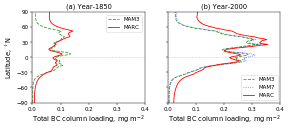

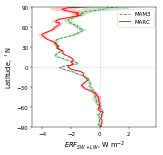

In [4]:
def zonal_mean_line_plot(year='2000', model_var_dict={'mam3': 'BURDENPOM'},
                         sf=None, xlabel=None, xlim=None,
                         ylabel=True, 
                         title=None,
                         ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # If no scale-factor specified, set as 1
    if sf is None:
        sf = 1
    # Loop over model-variable combinations
    for model, variable in model_var_dict.items():
        if variable is not None:
            # Color based on model
            if model == 'marc':
                c = 'r'
                alpha = 1
                linestyle = '-'
            elif model == 'mam3':
                c = 'g'
                alpha = 0.75
                linestyle = '--'
            elif model == 'mam7':
                c = 'b'
                alpha = 0.5
                linestyle = ':'
            # Case 1: single year (1850 or 2000)
            if year in ['1850', '2000']:
                # Load annual mean data
                in_filename = '{}/{}_{}_{}_ANN.nc'.format(in_dir, model, year, variable)
                data = xr.open_dataset(in_filename, decode_times=False)[variable] * sf
                data = data.isel(time=slice(2, None))  # exclude first two years as spin-up
                try:  # average across level dimension if it exists
                    data = data.mean(dim='lev')
                except ValueError:
                    pass
                if data.time.size != 30:  # check that exactly 30 years of data are present
                    raise RuntimeError('data.time.size = {} != 30'.format(data.time.size))
                # Calculate zonal mean
                zm = data.mean(dim='lon')
                # Plot line - showing mean across time
                tm = zm.mean(dim='time').data.flatten()
                ax.plot(tm, zm['lat'].data,
                        c=c, alpha=alpha, linestyle=linestyle,
                        label=model.upper())
                # Plot shading - based on standard error
                error = zm.std(dim='time', ddof=1).data.flatten() / np.sqrt(zm['time'].size)
                ax.fill_betweenx(zm['lat'].data, tm-error, tm+error,
                                 facecolor=c, alpha=0.2)
                # Close dataset
                data.close()
            # Case 2: difference (2000-1850)
            elif year == '2000-1850':
                # Load annual mean data
                in_filename_list = ['{}/{}_{}_{}_ANN.nc'.format(in_dir, model, '2000', variable),
                                    '{}/{}_{}_{}_ANN.nc'.format(in_dir, model, '1850', variable)]
                data_list = []
                for in_filename in in_filename_list:
                    data = xr.open_dataset(in_filename, decode_times=False)[variable] * sf
                    data = data.isel(time=slice(2, None))  # exclude first two years
                    try: # average across level dimension if it exists
                        data = data.mean(dim='lev')
                    except ValueError:
                        pass
                    if data.time.size != 30: # check that exactly 30 years of data are present
                        raise RuntimeError('data.time.size = {} != 30'.format(data.time.size))
                    data_list.append(data)
                # Calculate zonal means
                zm1 = data_list[0].mean(dim='lon')
                zm2 = data_list[1].mean(dim='lon')
                # If 3D field, get data for surface
                if 'lev' in zm1.dims:
                    zm1 = zm1.isel(lev=-1)
                    zm2 = zm2.isel(lev=-1)
                # Plot line - showing difference of means across time
                tm1 = zm1.mean(dim='time').data.flatten()
                tm2 = zm2.mean(dim='time').data.flatten()
                tm = tm1 - tm2
                ax.plot(tm, zm1['lat'].data,
                        c=c, alpha=alpha, linestyle=linestyle,
                        label=model.upper())
                # Plot shading - based on combined standard error
                error1 = zm1.std(dim='time', ddof=1).data.flatten() / np.sqrt(zm1['time'].size)
                error2 = zm2.std(dim='time', ddof=1).data.flatten() / np.sqrt(zm2['time'].size)
                error = np.sqrt(error1**2 + error2**2)
                ax.fill_betweenx(zm1['lat'].data, tm-error, tm+error,
                                 facecolor=c, alpha=0.2)
                # Close datasets
                for data in data_list:
                    data.close()
            else:
                raise ValueError('year not recognised')
    # Lines showing zero
    ax.axhline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    ax.axvline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    # y-axis
    ax.set_ylim([-90, 90])
    ax.set_yticks(np.arange(-90, 91, 30))
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='large')
    # x-axis
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='large')
    if xlim:
        ax.set_xlim(xlim)
    # Title and legend
    if title:
        ax.set_title(title, fontsize='large')
    ax.legend()
    return ax

# Examples
if True:
    # Example 1
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True, sharex=True)
    for year, model_var_dict, ylabel, title, ax in zip(['1850', '2000'],
                                                       [{'mam3': 'BURDENBC', 'marc': 'ctBC_LDG'},
                                                        {'mam3': 'BURDENBC', 'mam7': 'BURDENBC',
                                                         'marc': 'ctBC_LDG'}],
                                                       [True, False],
                                                       ['(a) Year-1850', '(b) Year-2000'],
                                                       axs):
        zonal_mean_line_plot(year=year,
                             model_var_dict=model_var_dict,
                             sf=1e6, xlabel=r'Total BC column loading, mg m$^{-2}$', xlim=[0, 0.4],
                             ylabel=ylabel, title=title, ax=ax)
    # Example 2
    ax = zonal_mean_line_plot(year='2000-1850', model_var_dict={'mam3': 'cFNTOA', 'marc': 'cFNTOA'},
                              xlabel=r'$ERF_{SW+LW}$, W m$^{-2}$')

## Function to produce map of differences

Mean = -1.57±0.04
Mean = -1.75±0.04


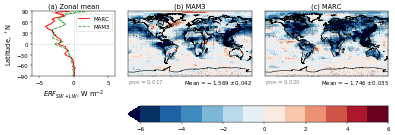

In [5]:
def difference_map(year='2000-1850', model='marc', variable='cFNTOA',
                   sf=None, vmin=-6, vmax=6, whiteout='0.0', cmap=None,
                   title=None,
                   ax=None):
    # Case 1: 2000-1850 difference
    if year == '2000-1850':
        in_filename_list = ['{}/{}_{}_{}_ANN.nc'.format(in_dir, model, '2000', variable),
                            '{}/{}_{}_{}_ANN.nc'.format(in_dir, model, '1850', variable),]
    else:
        raise NotImplementedError('Currently only 2000-1850 differences are implemented')
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # If no scale-factor specified, set as 1
    if sf is None:
        sf = 1
    # If no colormap specified, create one
    if cmap is None:
        cmap = plt.cm.get_cmap('RdBu_r', 12)
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
    # Load data
    data_list = []
    for in_filename in in_filename_list:
        data = xr.open_dataset(in_filename, decode_times=False)[variable] * sf
        data = data.isel(time=slice(2, None))  # exclude first two years
        data = climapy.xr_shift_lon(data, lon_min=-180.)  # shift longitudes by approx -180deg
        try:  # average across level dimension if it exists
            data = data.mean(dim='lev')
        except ValueError:
            pass
        if data.time.size != 30:  # check that exactly 30 years of data are present
            raise RuntimeError('data.time.size = {} != 30'.format(data.time.size))
        data_list.append(data)
    # Calculate means across time
    tm_list = []
    for data in data_list:
        tm = data.mean(dim='time').data
        tm_list.append(tm)
    tm_diff = tm_list[0] - tm_list[1]  # difference
    # Find where statistically significant and larger than whiteout value
    p_values = stats.ttest_ind(data_list[0].data,
                               data_list[1].data,
                               equal_var=False)[1]  # Welch's t-test
    if np.isnan(p_values).any():  # check for NaNs in p_values and replace with ones...
        w_replace = np.where(np.isnan(p_values) & (tm_diff == 0.))  #... if tm_diff is zero
        p_values[w_replace] = 1.
    p_fdr = climapy.stats_fdr(p_values, alpha=0.05)  # p-value threshold for alpha=0.05
    w_sig = np.where((p_values.ravel() <= p_fdr) &  # statistically significant &
                     (np.abs(tm_diff.ravel()) > float(whiteout)))  # larger than whiteout value
    lon_sig, lat_sig = np.meshgrid(data_list[0]['lon'].data, data_list[1]['lat'].data)
    lon_sig = lon_sig.ravel()[w_sig]
    lat_sig = lat_sig.ravel()[w_sig]
    # Lower bound for first longitude bin (important for map)
    lon0 = (data['lon'][0] - (data['lon'][1]-data['lon'][0])/2.0).data
    # Pseudo-lower bound for first latitude bin (used for stretching imshow)
    lat0 = (data['lat'][0] - (data['lat'][1]-data['lat'][0])/2.0).data
    # Map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(ax=ax)
    # Plot field and stippling
    tm_diff_masked = np.ma.masked_inside(tm_diff, -1*float(whiteout), float(whiteout))
    im = ax.imshow(tm_diff_masked,
                   extent=[lon0, 360+lon0, -lat0, lat0],
                   vmin=vmin, vmax=vmax, cmap=cmap, aspect='auto')
    ax.scatter(lon_sig, lat_sig, marker='.', s=0.05, c='k')
    # Annotate with p-value threshold
    ax.text(-180, -105, r'$p_{{FDR}}\approx{:.3f}$'.format(p_fdr),
            color='0.5', horizontalalignment='left', verticalalignment='center')
    # Annotate with area-weighted mean
    mean_list = []  # list to hold area-weighted means
    error_list = []  # list to hold standard errors on means
    for data in data_list:
        awm = climapy.xr_area_weighted_stat(data)
        mean_list.append(awm.mean(dim='time').data)
        error = awm.std(dim='time', ddof=1).data.flatten() / np.sqrt(awm['time'].size)
        error_list.append(error)
    mean_diff = mean_list[0] - mean_list[1]
    error = float(np.sqrt(error_list[0]**2 + error_list[1]**2))  # combine errors
    ax.text(180, -105, 'Mean$={:+.3f}\pm{:.3f}$'.format(mean_diff, error),
            color='k', horizontalalignment='right', verticalalignment='center')
    # Print area-weighted mean to 2dp (for quoting in manuscript)
    print('Mean = {:+.2f}±{:.2f}'.format(mean_diff, error))
    # Close datasets
    for data in data_list:
        data.close()
    # Title
    if title:
        ax.set_title(title, fontsize='large')
    return ax, im, tm_diff

# Examples
if True:
    # Example 1
    fig = plt.figure(figsize=(10, 3.5))
    gs = gridspec.GridSpec(2, 3, height_ratios=[4, 1], width_ratios=[2, 3, 3])
    zonal_mean_line_plot(year='2000-1850', model_var_dict={'marc': 'cFNTOA', 'mam3': 'cFNTOA'},
                         sf=None, xlabel=r'$ERF_{SW+LW}$, W m$^{-2}$', xlim=[-6, 6],
                         ylabel=True, title='(a) Zonal mean', ax=plt.subplot(gs[0, 0]))
    ax, im, tm_diff1 = difference_map(year='2000-1850', model='mam3', variable='cFNTOA', vmin=-6, vmax=6,
                                      title='(b) MAM3', ax=plt.subplot(gs[0, 1]))
    ax, im, tm_diff2 = difference_map(year='2000-1850', model='marc', variable='cFNTOA', vmin=-6, vmax=6,
                                      title='(c) MARC', ax=plt.subplot(gs[0, 2]))
    if max(tm_diff1.max(), tm_diff2.max()) > 6 and min(tm_diff1.min(), tm_diff2.min()) < -6:
        extend = 'both'
    elif max(tm_diff1.max(), tm_diff2.max()) > 6:
        extend = 'max'
    elif min(tm_diff1.min(), tm_diff2.min()) < -6:
        extend = 'min'
    else:
        extend = False
    fig.colorbar(im, cax=plt.subplot(gs[1, 1:]), orientation='horizontal', extend=extend)
    fig.tight_layout()

## Function to produce map of field
i.e. not the differences between two fields

Mean = -1.58±0.00
Mean = -1.48±0.01


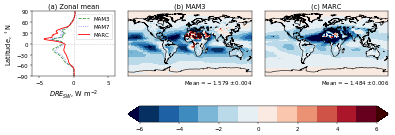

In [6]:
def field_map(year='2000', model='marc', variable='cDRE',
              sf=None, vmin=-6, vmax=6, whiteout=None, cmap=None,
              title=None,
              ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # If no scale-factor specified, set as 1
    if sf is None:
        sf = 1
    # If no cmap specified, create one
    if cmap is None:
        cmap = plt.cm.get_cmap('RdBu_r', 12)
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
    # Load data
    in_filename = '{}/{}_{}_{}_ANN.nc'.format(in_dir, model, year, variable)
    data = xr.open_dataset(in_filename, decode_times=False)[variable] * sf
    data = data.isel(time=slice(2, None))  # exclude first two years
    data = climapy.xr_shift_lon(data, lon_min=-180.)  # shift longitudes by approx -180deg
    try:  # average across level dimension if it exists
        data = data.mean(dim='lev')
    except ValueError:
        pass
    if data.time.size != 30:  # check that exactly 30 years of data are present
        raise RuntimeError('data.time.size = {} != 30'.format(data.time.size))
    # Calculate means across time
    tm = data.mean(dim='time').data
    # Lower bound for first longitude bin (important for map)
    lon0 = (data['lon'][0] - (data['lon'][1]-data['lon'][0])/2.0).data
    # Pseudo-lower bound for first latitude bin (used for stretching imshow)
    lat0 = (data['lat'][0] - (data['lat'][1]-data['lat'][0])/2.0).data
    # Map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(ax=ax)
    # Plot field
    if whiteout:
        tm_temp = np.ma.masked_inside(tm, -1*float(whiteout), float(whiteout))
    else:  # if no whiteout specified, still whiteout zero
        tm_temp = np.ma.masked_equal(tm, 0.0)
    im = ax.imshow(tm_temp,
                   extent=[lon0, 360+lon0, -lat0, lat0],
                   vmin=vmin, vmax=vmax, cmap=cmap, aspect='auto')
    # Annotate with area-weighted mean and standard error
    awm = climapy.xr_area_weighted_stat(data)
    error = awm.std(dim='time', ddof=1).data.flatten() / np.sqrt(awm['time'].size)
    awm = awm.mean(dim='time').data
    ax.text(180, -105, 'Mean$={:+.3f}\pm{:.3f}$'.format(float(awm), float(error)),
            color='k', horizontalalignment='right', verticalalignment='center')
    # Print area-weighted mean to 2dp (for quoting in manuscript)
    print('Mean = {:+.2f}±{:.2f}'.format(float(awm), float(error)))
    # Close dataset
    data.close()
    # Title
    if title:
        ax.set_title(title, fontsize='large')
    return ax, im, tm

# Example
if True:
    # Example 1
    fig = plt.figure(figsize=(10, 3.5))
    gs = gridspec.GridSpec(2, 3, height_ratios=[4, 1], width_ratios=[2, 3, 3])
    zonal_mean_line_plot(year='2000',
                         model_var_dict={'mam3': 'cDRE', 'mam7': 'cDRE', 'marc': 'cDRE'},
                         sf=None, xlabel=r'$DRE_{SW}$, W m$^{-2}$', xlim=[-6, 6],
                         ylabel=True, title='(a) Zonal mean', ax=plt.subplot(gs[0, 0]))
    ax, im, tm1 = field_map(year='2000', model='mam3', variable='cDRE', vmin=-6, vmax=6,
                            title='(b) MAM3', ax=plt.subplot(gs[0, 1]))
    ax, im, tm2 = field_map(year='2000', model='marc', variable='cDRE', vmin=-6, vmax=6,
                            title='(c) MARC', ax=plt.subplot(gs[0, 2]))
    if max(tm1.max(), tm2.max()) > 6 and min(tm1.min(), tm2.min()) < -6:
        extend = 'both'
    elif max(tm1.max(), tm2.max()) > 6:
        extend = 'max'
    elif min(tm1.min(), tm2.min()) < -6:
        extend = 'min'
    else:
        extend = False
    fig.colorbar(im, cax=plt.subplot(gs[1, 1:]), orientation='horizontal', extend=extend)
    fig.tight_layout()

## Function to produce zonal means and maps for 2000-1850

Mean = -0.02±0.01
Mean = -0.18±0.01


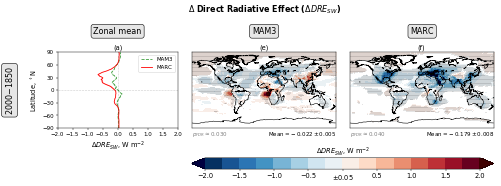

In [7]:
def zonal_means_maps_diff(model_var_dict={'mam3': 'cDRE', 'marc': 'cDRE', },
                          main_title='$\Delta$ Direct Radiative Effect ($\Delta DRE_{SW}$)',
                          xlabel='$\Delta DRE_{SW}$, W m$^{-2}$', sf=None,
                          xlim=[-2, 2], whiteout='0.05', cmap='RdBu_r', nlev=16,
                          file_prefix=None):
    fig = plt.figure(figsize=(12, 3.75))
    gs = gridspec.GridSpec(2, 3,  # 2nd row is for colorbar
                           height_ratios=[1, 0.15], width_ratios=[2.5, 3, 3])
    axs = []  # list to hold axes
    year = '2000-1850'
    # 1st column: zonal means
    ax = plt.subplot(gs[0, 0])
    axs.append(ax)
    zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                         xlabel=xlabel, sf=sf, xlim=xlim,
                         ylabel=True, title='({})'.format(chr(97)), ax=ax)
    xticks = np.arange(xlim[0], xlim[1]+1e-10, (xlim[1]-xlim[0])/(nlev/2))
    plt.xticks(xticks)
    # Row title
    ax.text(xlim[0]-(xlim[1]-xlim[0])*0.4, 0, '$-$'.join(year.split('-')),
            fontsize='x-large', verticalalignment='center', horizontalalignment='center',
            rotation=90,
            bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
    # Discretise colour map
    cmap = plt.cm.get_cmap(cmap, nlev)
    cmap.set_under([0, 0, 0.25])
    cmap.set_over([0.25, 0, 0])
    # 2nd & 3rd columns: maps
    tm_list = []  # list to hold arrays from maps, for colorbar extension
    for model, c in zip(['mam3', 'marc'], [1, 2]):
        ax = plt.subplot(gs[0, c])
        axs.append(ax)
        if model_var_dict[model] is not None:
            ax, im, tm = difference_map(year=year, model=model, variable=model_var_dict[model],
                                        sf=sf,
                                        vmin=xlim[0], vmax=xlim[1], whiteout=whiteout, cmap=cmap,
                                        title='({})'.format(chr(97+3+c)), ax=ax)
            tm_list.append(tm)
        else:  # setup empty plot if no data for a given model
            bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=-181.75, urcrnrlon=-181.75+360., ax=ax)    
            bm.drawcoastlines(ax=ax)
            ax.imshow(np.full([2, 2], np.nan), aspect='auto')
    # Colorbar
    tm_max = max([tm.max() for tm in tm_list])
    tm_min = min([tm.min() for tm in tm_list])
    if tm_min < xlim[0] and tm_max > xlim[1]:
        extend = 'both'
    elif tm_min < xlim[0]:
        extend = 'min'
    elif tm_max > xlim[1]:
        extend = 'max'
    else:
        extend = 'neither'
    cbar = fig.colorbar(im, cax=plt.subplot(gs[1, 1:]), orientation='horizontal',
                        ticks=xticks, extend=extend)
    if whiteout:
        tick_labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
        tick_labels[int(nlev/4)] = r'$\pm$' + whiteout
        cbar.ax.set_xticklabels(tick_labels, fontsize='large')
    cbar.set_label(xlabel, fontsize='large', labelpad=7)
    cbar.ax.xaxis.set_label_position('top')
    # Column titles
    axs[0].text((xlim[0]+xlim[1])/2, 140, 'Zonal mean',
                fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
    for ax, title in zip(axs[1:3], ['MAM3', 'MARC']):
        ax.text(0, 140, title,
                fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
    # Main title
    axs[1].text(0, 190, main_title,
                fontsize='x-large', fontweight='bold',
                verticalalignment='center', horizontalalignment='center')   
    # Prevent overlapping labels
    fig.tight_layout()
    # Save
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    return fig

# Example
if True:
    fig = zonal_means_maps_diff()

## Function to produce zonal means and maps for 2000 and 2000-1850

Mean = -1.58±0.00
Mean = -1.48±0.01
Mean = -0.02±0.01
Mean = -0.18±0.01


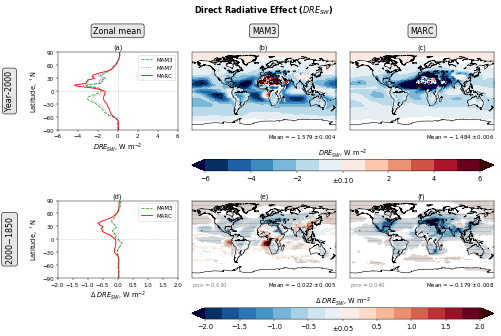

In [8]:
def zonal_means_maps_2000_diff(model_var_dict={'mam3': 'cDRE', 'mam7': 'cDRE', 'marc': 'cDRE'},
                               main_title='Direct Radiative Effect ($DRE_{SW}$)',
                               xlabel='$DRE_{SW}$, W m$^{-2}$', sf=None,
                               xlim_2000=[-6, 6], whiteout_2000='0.10', cmap_2000='RdBu_r', nlev_2000=12,
                               xlim_diff=[-2, 2], whiteout_diff='0.05', cmap_diff='RdBu_r', nlev_diff=16,
                               file_prefix=None):
    fig = plt.figure(figsize=(12, 7.5))
    gs = gridspec.GridSpec(4, 3,  # 2nd and 4th rows are for colorbar
                           height_ratios=[1, 0.15, 1, 0.15], width_ratios=[2.5, 3, 3])
    axs = []  # list to hold axes
    # Loop over year-2000 and 2000-1850 (rows)
    for year, xlim, whiteout, cmap, nlev, r in zip(['2000', '2000-1850'],
                                                   [xlim_2000, xlim_diff], [whiteout_2000, whiteout_diff],
                                                   [cmap_2000, cmap_diff], [nlev_2000, nlev_diff],
                                                   [0, 2]):
        # 1st column: zonal means
        ax = plt.subplot(gs[r, 0])
        axs.append(ax)
        if r == 0:
            xlabel_temp = xlabel
        else:
            xlabel_temp = r'$\Delta$ ' + xlabel
        model_var_dict_temp = model_var_dict.copy()
        if year != '2000':
            model_var_dict_temp.pop('mam7', None)
        zonal_mean_line_plot(year=year, model_var_dict=model_var_dict_temp,
                             xlabel=xlabel_temp, sf=sf, xlim=xlim,
                             ylabel=True, title='({})'.format(chr(97+int(r/2*3))), ax=ax)
        xticks = np.arange(xlim[0], xlim[1]+1e-10, (xlim[1]-xlim[0])/(nlev/2))
        plt.xticks(xticks)
        # Row title
        if '-' in year:
            ax.text(xlim[0]-(xlim[1]-xlim[0])*0.4, 0, '$-$'.join(year.split('-')),
                    fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                    rotation=90,
                    bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
        else:
            ax.text(xlim[0]-(xlim[1]-xlim[0])*0.4, 0, 'Year-{}'.format(year),
                    fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                    rotation=90,
                    bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
        # Discretise colour map
        cmap = plt.cm.get_cmap(cmap, nlev)
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
        # 2nd & 3rd columns: maps
        tm_list = []  # list to hold arrays from maps, for colorbar extension
        for model, c in zip(['mam3', 'marc'], [1, 2]):
            ax = plt.subplot(gs[r, c])
            axs.append(ax)
            if model_var_dict[model] is not None:
                if r == 0:
                    ax, im, tm = field_map(year=year, model=model, variable=model_var_dict[model],
                                           sf=sf,
                                           vmin=xlim[0], vmax=xlim[1], whiteout=whiteout, cmap=cmap,
                                           title='({})'.format(chr(97+c)), ax=ax)
                else:
                    ax, im, tm = difference_map(year=year, model=model, variable=model_var_dict[model],
                                                sf=sf,
                                                vmin=xlim[0], vmax=xlim[1], whiteout=whiteout, cmap=cmap,
                                                title='({})'.format(chr(97+3+c)), ax=ax)
                tm_list.append(tm)
            else:  # setup empty plot
                bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=-181.75, urcrnrlon=-181.75+360., ax=ax)    
                bm.drawcoastlines(ax=ax)
                ax.imshow(np.full([2, 2], np.nan), aspect='auto')
        # Colorbar
        tm_max = max([tm.max() for tm in tm_list])
        tm_min = min([tm.min() for tm in tm_list])
        if tm_min < xlim[0] and tm_max > xlim[1]:
            extend = 'both'
        elif tm_min < xlim[0]:
            extend = 'min'
        elif tm_max > xlim[1]:
            extend = 'max'
        else:
            extend = 'neither'
        cbar = fig.colorbar(im, cax=plt.subplot(gs[r+1, 1:]), orientation='horizontal',
                            ticks=xticks, extend=extend)
        if whiteout:
            tick_labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
            tick_labels[int(nlev/4)] = r'$\pm$' + whiteout
            cbar.ax.set_xticklabels(tick_labels, fontsize='large')
        cbar.set_label(xlabel_temp, fontsize='large', labelpad=7)
        cbar.ax.xaxis.set_label_position('top')
    # Column titles
    axs[0].text((xlim_2000[0]+xlim_2000[1])/2, 140, 'Zonal mean',
                fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
    for ax, title in zip(axs[1:3], ['MAM3', 'MARC']):
        ax.text(0, 140, title,
                fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
    # Main title
    axs[1].text(0, 190, main_title,
                fontsize='x-large', fontweight='bold',
                verticalalignment='center', horizontalalignment='center')   
    # Prevent overlapping labels
    fig.tight_layout()
    # Save
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    return fig

# Example
if True:
    fig = zonal_means_maps_2000_diff()

## Figures for main manuscript

In [9]:
figure_counter = 1  # initialise counter to keep track of figure number

### Aerosol burdens

Mean = +2.99±0.01
Mean = +2.53±0.01
Mean = +2.02±0.01
Mean = +1.54±0.01
Written local/f01.pdf


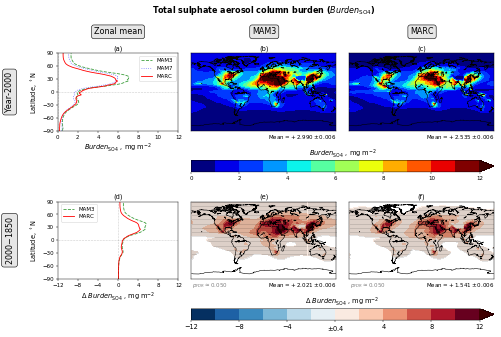

In [10]:
# Total sulphate column burden
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'BURDENSO4', 'mam7': 'BURDENSO4',
                                                 'marc': 'SUL_LDG', },
                                 main_title=r'Total sulphate aerosol column burden ($Burden_\mathrm{SO4}$)',
                                 xlabel=r'$Burden_\mathrm{SO4}$ , mg m$^{-2}$', sf=1e6,
                                 xlim_2000=[0, 12], whiteout_2000=None, cmap_2000='jet', nlev_2000=12,
                                 xlim_diff=[-12, 12], whiteout_diff='0.4', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +1.12±0.00
Mean = +2.61±0.00
Mean = +0.42±0.00
Mean = +0.31±0.01
Written local/f02.pdf


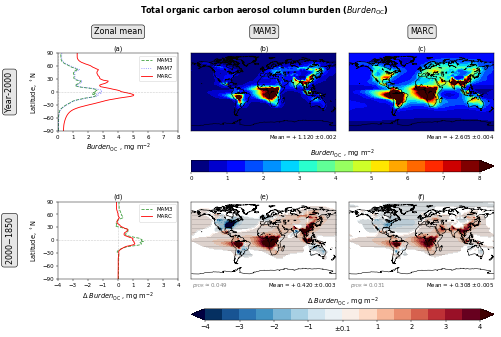

In [11]:
# Total OC column loading
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'BURDENPOM', 'mam7': 'BURDENPOM',
                                                 'marc': 'ctOC_LDG', },
                                 main_title=r'Total organic carbon aerosol column burden ($Burden_\mathrm{OC}$)',
                                 xlabel=r'$Burden_\mathrm{OC}$ , mg m$^{-2}$', sf=1e6,
                                 xlim_2000=[0, 8], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-4, 4], whiteout_diff='0.1', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +0.16±0.00
Mean = +0.18±0.00
Mean = +0.09±0.00
Mean = +0.11±0.00
Written local/f03.pdf


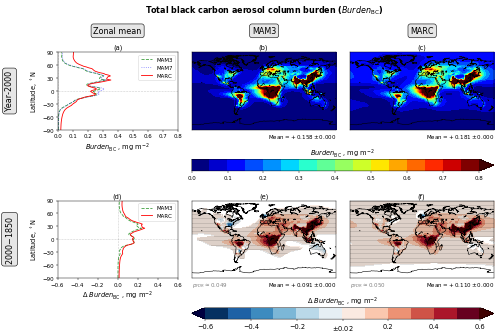

In [12]:
# Total BC column burden
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'BURDENBC', 'mam7': 'BURDENBC',
                                                 'marc': 'ctBC_LDG', },
                                 main_title=r'Total black carbon aerosol column burden ($Burden_\mathrm{BC}$)',
                                 xlabel=r'$Burden_\mathrm{BC}$ , mg m$^{-2}$', sf=1e6,
                                 xlim_2000=[0, 0.8], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-0.6, 0.6], whiteout_diff='0.02', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +19.65±0.05
Mean = +18.83±0.03
Mean = +0.05±0.06
Mean = -0.16±0.05
Written local/f04.pdf


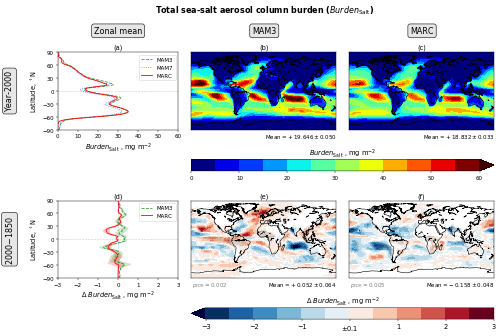

In [13]:
# Total sea-salt column burden
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'BURDENSEASALT', 'mam7': 'BURDENSEASALT',
                                                 'marc': 'ctSSLT_LDG', },
                                 main_title=r'Total sea-salt aerosol column burden ($Burden_\mathrm{Salt}$)',
                                 xlabel=r'$Burden_\mathrm{Salt}$ , mg m$^{-2}$', sf=1e6,
                                 xlim_2000=[0, 60], whiteout_2000=None, cmap_2000='jet', nlev_2000=12,
                                 xlim_diff=[-3, 3], whiteout_diff='0.1', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +47.32±0.33
Mean = +79.80±0.50
Mean = -1.73±0.42
Mean = -1.79±0.77
Written local/f05.pdf


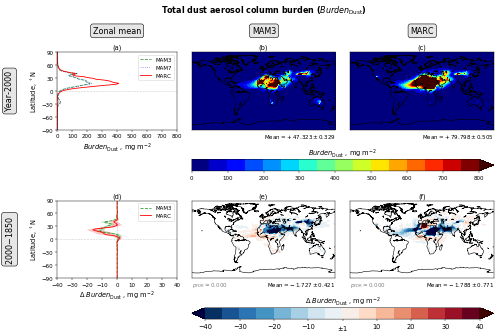

In [14]:
# Total dust column burden
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'BURDENDUST', 'mam7': 'BURDENDUST',
                                                 'marc': 'ctDST_LDG', },
                                 main_title=r'Total dust aerosol column burden ($Burden_\mathrm{Dust}$)',
                                 xlabel=r'$Burden_\mathrm{Dust}$ , mg m$^{-2}$', sf=1e6,
                                 xlim_2000=[0, 800], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-40, 40], whiteout_diff='1', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

### Direct radiative effect

Mean = +0.12±0.00
Mean = +0.08±0.00
Mean = +0.01±0.00
Mean = +0.00±0.00
Written local/f06.pdf


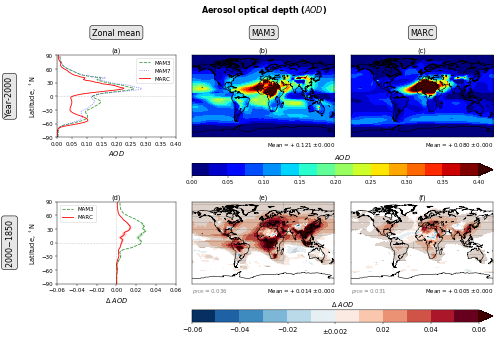

In [15]:
# Aerosol optical depth
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'AEROD_v', 'mam7': 'AEROD_v',
                                                 'marc': 'TAU_tot', },
                                 main_title=r'Aerosol optical depth ($AOD$)',
                                 xlabel=r'$AOD$', sf=None,
                                 xlim_2000=[0, 0.4], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-0.06, 0.06], whiteout_diff='0.002', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = -1.58±0.00
Mean = -1.48±0.01
Mean = -0.02±0.01
Mean = -0.18±0.01
Written local/f07.pdf


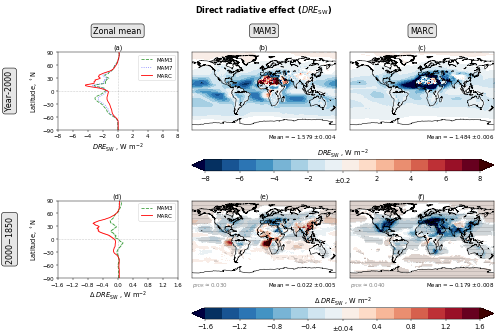

In [16]:
# Direct radiative effect at TOA
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'cDRE', 'mam7': 'cDRE', 'marc': 'cDRE', },
                                 main_title=r'Direct radiative effect ($DRE_\mathrm{SW}$)',
                                 xlabel=r'$DRE_\mathrm{SW}$ , W m$^{-2}$',
                                 xlim_2000=[-8, 8], whiteout_2000='0.2', cmap_2000='RdBu_r', nlev_2000=16,
                                 xlim_diff=[-1.6, 1.6], whiteout_diff='0.04', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +2.85±0.01
Mean = +1.74±0.01
Mean = +0.57±0.01
Mean = +0.29±0.01
Written local/f08.pdf


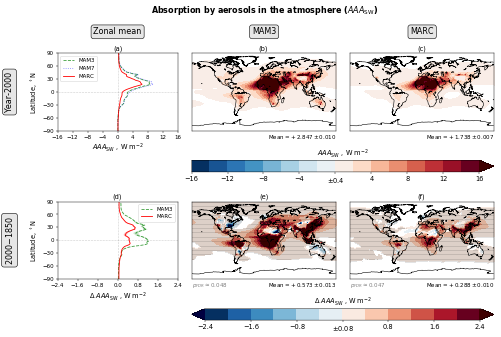

In [17]:
# Absorption by aerosols in the atmosphere
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'cAAA', 'mam7': 'cAAA', 'marc': 'cAAA', },
                                 main_title=r'Absorption by aerosols in the atmosphere ($AAA_\mathrm{SW}$)',
                                 xlabel=r'$AAA_\mathrm{SW}$ , W m$^{-2}$',
                                 xlim_2000=[-16, 16], whiteout_2000='0.4', cmap_2000='RdBu_r', nlev_2000=16,
                                 xlim_diff=[-2.4, 2.4], whiteout_diff='0.08', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

### Cloud radiative effect

Mean = +59.41±0.09
Mean = +23.01±0.07
Mean = +21.12±0.11
Mean = +12.27±0.08
Written local/f09.pdf


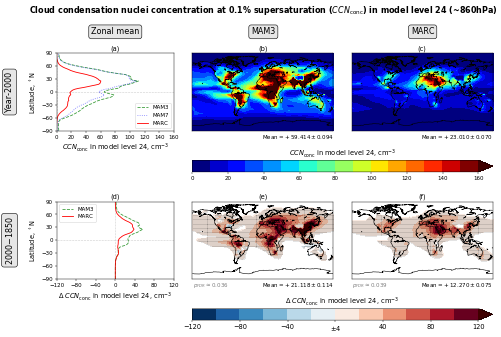

In [18]:
# CCN in level 24 (~860hPa)
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'CCN3_ml24', 'mam7': 'CCN3_ml24',
                                                 'marc': 'CCN3_ml24'},
                                 main_title=(r'Cloud condensation nuclei concentration at 0.1% supersaturation '
                                             r'($CCN_\mathrm{conc}$) in model level 24 (~860hPa)'),
                                 xlabel=r'$CCN_\mathrm{conc}$ in model level 24, cm$^{-3}$',
                                 xlim_2000=[0, 160], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-120, 120], whiteout_diff='4', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +1.41±0.00
Mean = +0.89±0.00
Mean = +0.38±0.00
Mean = +0.21±0.00
Written local/f10.pdf


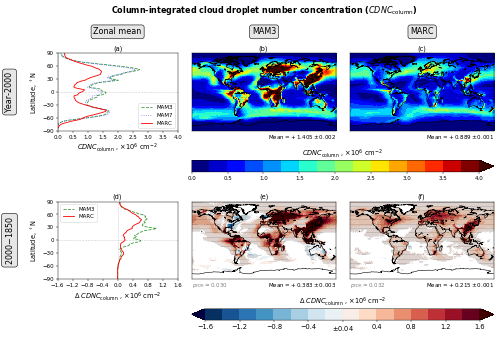

In [19]:
# Column-integrated droplet number concentration
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'CDNUMC', 'mam7': 'CDNUMC', 'marc': 'CDNUMC'},
                                 main_title=(r'Column-integrated cloud droplet number concentration '
                                             r'($CDNC_\mathrm{column}$)'),
                                 xlabel=r'$CDNC_\mathrm{column}$ , ×$10^6$ cm$^{-2}$', sf=1e-10,
                                 xlim_2000=[0, 4], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-1.6, 1.6], whiteout_diff='0.04', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +45.06±0.04
Mean = +46.63±0.05
Mean = +3.53±0.06
Mean = +3.67±0.07
Written local/f11.pdf


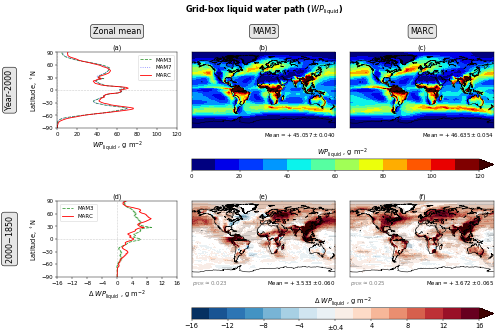

In [20]:
# Grid-box Liquid Water Path
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'TGCLDLWP', 'mam7': 'TGCLDLWP',
                                                 'marc': 'TGCLDLWP'},
                                 main_title=r'Grid-box liquid water path ($WP_\mathrm{liquid}$)',
                                 xlabel=r'$WP_\mathrm{liquid}$ , g m$^{-2}$', sf=1e3,
                                 xlim_2000=[0, 120], whiteout_2000=None, cmap_2000='jet', nlev_2000=12,
                                 xlim_diff=[-16, 16], whiteout_diff='0.4', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +17.67±0.02
Mean = +10.64±0.01
Mean = +0.17±0.02
Mean = +0.06±0.02
Written local/f12.pdf


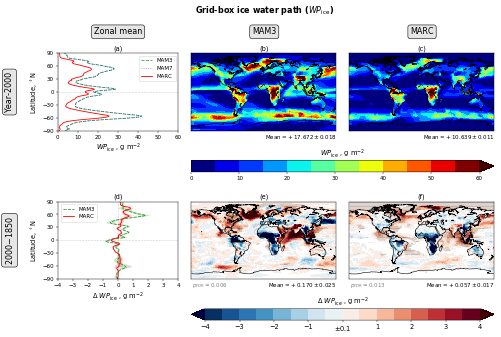

In [21]:
# Grid-box Ice Water Path
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'TGCLDIWP', 'mam7': 'TGCLDIWP',
                                                 'marc': 'TGCLDIWP'},
                                 main_title=r'Grid-box ice water path ($WP_\mathrm{ice}$)',
                                 xlabel=r'$WP_\mathrm{ice}$ , g m$^{-2}$', sf=1e3,
                                 xlim_2000=[0, 60], whiteout_2000=None, cmap_2000='jet', nlev_2000=12,
                                 xlim_diff=[-4, 4], whiteout_diff='0.1', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = -53.92±0.03
Mean = -52.20±0.03
Mean = -2.09±0.04
Mean = -2.11±0.03
Written local/f13.pdf


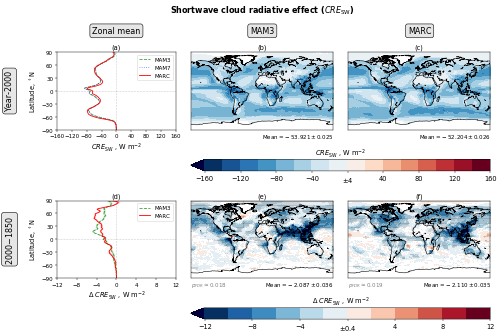

In [22]:
# SW cloud radiative effect at TOA
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'SWCF_d1', 'mam7': 'SWCF_d1', 'marc': 'CRF'},
                                 main_title=r'Shortwave cloud radiative effect ($CRE_\mathrm{SW}$)',
                                 xlabel=r'$CRE_\mathrm{SW}$ , W m$^{-2}$',
                                 xlim_2000=[-160, 160], whiteout_2000='4', cmap_2000='RdBu_r', nlev_2000=16,
                                 xlim_diff=[-12, 12], whiteout_diff='0.4', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Mean = +24.08±0.02
Mean = +22.18±0.01
Mean = +0.54±0.02
Mean = +0.66±0.02
Written local/f14.pdf


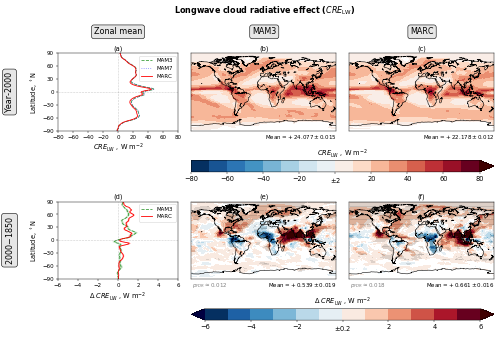

In [23]:
# LW cloud radiative effect at TOA
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'LWCF', 'mam7': 'LWCF', 'marc': 'LWCF'},
                                 main_title=r'Longwave cloud radiative effect ($CRE_\mathrm{LW}$)',
                                 xlabel=r'$CRE_\mathrm{LW}$ , W m$^{-2}$',
                                 xlim_2000=[-80, 80], whiteout_2000='2', cmap_2000='RdBu_r', nlev_2000=16,
                                 xlim_diff=[-6, 6], whiteout_diff='0.2', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

### Surface albedo radiative effect

Mean = +0.00±0.02
Mean = -0.12±0.02
Written local/f15.pdf


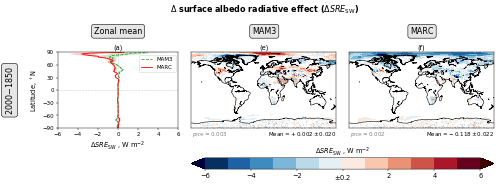

In [24]:
# Surface albedo radiative effect
fig = zonal_means_maps_diff(model_var_dict={'mam3': 'FSNTOAC_d1', 'marc': 'FSNTOACNOA'},
                            main_title=r'$\Delta$ surface albedo radiative effect ($\Delta SRE_\mathrm{SW}$)',
                            xlabel=r'$\Delta SRE_\mathrm{SW}$ , W m$^{-2}$', sf=None,
                            xlim=[-6, 6], whiteout='0.2', cmap='RdBu_r', nlev=12,
                            file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

### Net effective radiative forcing

Mean = -1.57±0.04
Mean = -1.75±0.04
Written local/f16.pdf


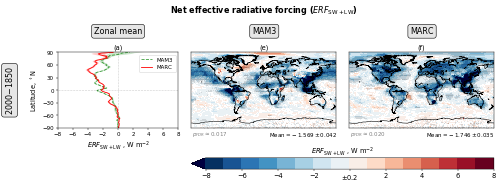

In [25]:
# Net ERF
fig = zonal_means_maps_diff(model_var_dict={'mam3': 'cFNTOA', 'marc': 'cFNTOA'},
                            main_title=r'Net effective radiative forcing ($ERF_\mathrm{SW+LW}$)',
                            xlabel=r'$ERF_\mathrm{SW+LW}$ , W m$^{-2}$', sf=None,
                            xlim=[-8, 8], whiteout='0.2', cmap='RdBu_r', nlev=16,
                            file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

## Figures for Supplement

In [26]:
supp_figure_counter = 1  # figure counter for supplementary figures

### CCN (supplement)

Mean = +113.03±0.13
Mean = +30.10±0.07
Mean = +40.27±0.15
Mean = +15.42±0.08
Written local/fS01.pdf


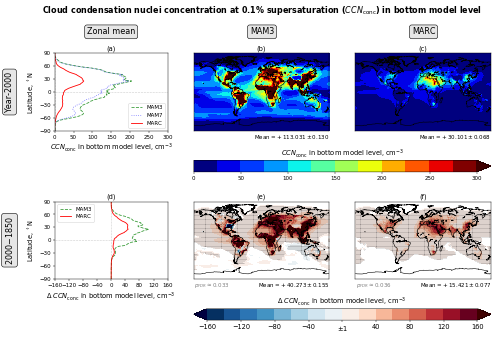

In [27]:
# CCN in bottom model level
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'CCN3_ml30', 'mam7': 'CCN3_ml30',
                                                 'marc': 'CCN3_ml30'},
                                 main_title=(r'Cloud condensation nuclei concentration at 0.1% supersaturation '
                                             r'($CCN_\mathrm{conc}$) in bottom model level'),
                                 xlabel='$CCN_\mathrm{conc}$ in bottom model level, cm$^{-3}$',
                                 xlim_2000=[0, 300], whiteout_2000=None, cmap_2000='jet', nlev_2000=12,
                                 xlim_diff=[-160, 160], whiteout_diff='1', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +8.73±0.02
Mean = +3.10±0.01
Mean = +3.36±0.02
Mean = +1.91±0.01
Written local/fS02.pdf


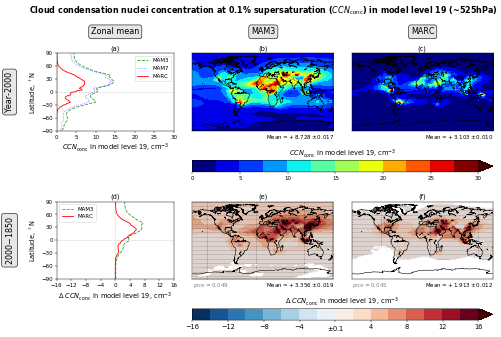

In [28]:
# CCN in level 19 (~525hPa)
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'CCN3_ml19', 'mam7': 'CCN3_ml19',
                                                 'marc': 'CCN3_ml19'},
                                 main_title=(r'Cloud condensation nuclei concentration at 0.1% supersaturation '
                                             r'($CCN_\mathrm{conc}$) in model level 19 (~525hPa)'),
                                 xlabel=r'$CCN_\mathrm{conc}$ in model level 19, cm$^{-3}$',
                                 xlim_2000=[0, 30], whiteout_2000=None, cmap_2000='jet', nlev_2000=12,
                                 xlim_diff=[-16, 16], whiteout_diff='0.1', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

### Water path and cloud fraction (supplement)

Mean = +62.73±0.05
Mean = +57.27±0.05
Mean = +3.70±0.07
Mean = +3.73±0.07
Written local/fS03.pdf


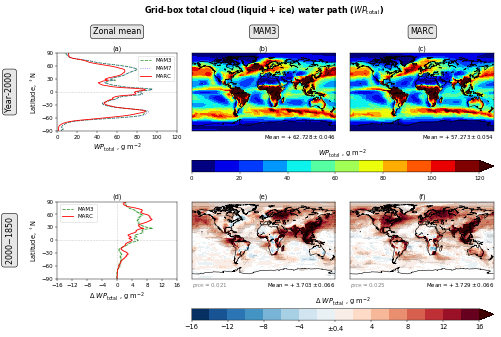

In [29]:
# Grid-box Total Water Path
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'TGCLDCWP', 'mam7': 'TGCLDCWP',
                                                 'marc': 'TGCLDCWP'},
                                 main_title=(r'Grid-box total cloud (liquid + ice) water path '
                                             r'($WP_\mathrm{total}$)'),
                                 xlabel=r'$WP_\mathrm{total}$ , g m$^{-2}$', sf=1e3,
                                 xlim_2000=[0, 120], whiteout_2000=None, cmap_2000='jet', nlev_2000=12,
                                 xlim_diff=[-16, 16], whiteout_diff='0.4', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +0.64±0.00
Mean = +0.64±0.00
Mean = +0.00±0.00
Mean = +0.00±0.00
Written local/fS04.pdf


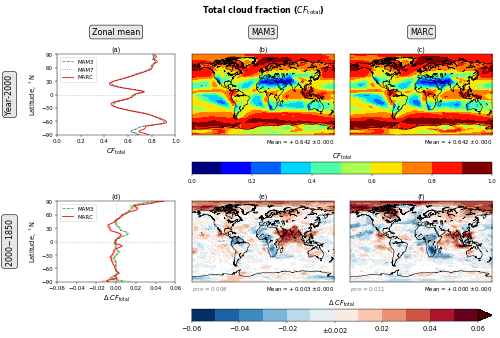

In [30]:
# Total cloud fraction
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'CLDTOT', 'mam7': 'CLDTOT', 'marc': 'CLDTOT'},
                                 main_title=r'Total cloud fraction ($CF_\mathrm{total}$)',
                                 xlabel=r'$CF_\mathrm{total}$', sf=None,
                                 xlim_2000=[0, 1], whiteout_2000=None, cmap_2000='jet', nlev_2000=10,
                                 xlim_diff=[-0.06, 0.06], whiteout_diff='0.002', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +0.44±0.00
Mean = +0.42±0.00


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +0.00±0.00


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +0.00±0.00
Written local/fS05.pdf


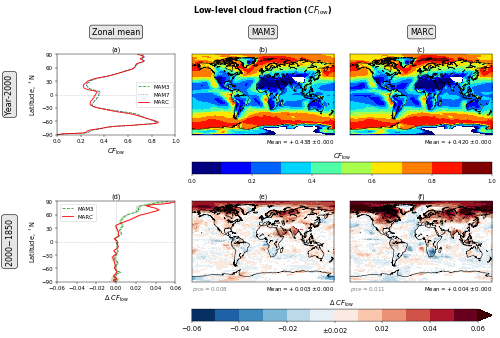

In [31]:
# Low cloud fraction
# Note: warnings arise due to calculation of p-values for locations with zero low cloud fraction
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'CLDLOW', 'mam7': 'CLDLOW', 'marc': 'CLDLOW'},
                                 main_title=r'Low-level cloud fraction ($CF_\mathrm{low}$)',
                                 xlabel=r'$CF_\mathrm{low}$', sf=None,
                                 xlim_2000=[0, 1], whiteout_2000=None, cmap_2000='jet', nlev_2000=10,
                                 xlim_diff=[-0.06, 0.06], whiteout_diff='0.002', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +0.27±0.00
Mean = +0.27±0.00
Mean = +0.00±0.00
Mean = +0.00±0.00
Written local/fS06.pdf


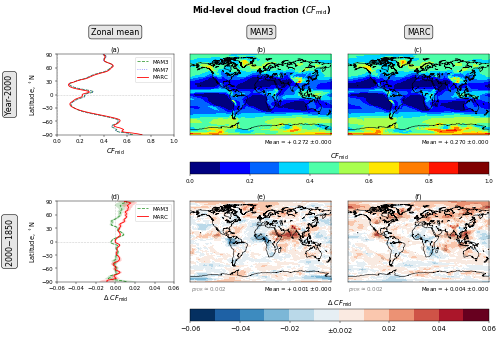

In [32]:
# Mid cloud fraction
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'CLDMED', 'mam7': 'CLDMED', 'marc': 'CLDMED'},
                                 main_title=r'Mid-level cloud fraction ($CF_\mathrm{mid}$)',
                                 xlabel=r'$CF_\mathrm{mid}$', sf=None,
                                 xlim_2000=[0, 1], whiteout_2000=None, cmap_2000='jet', nlev_2000=10,
                                 xlim_diff=[-0.06, 0.06], whiteout_diff='0.002', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +0.38±0.00
Mean = +0.40±0.00
Mean = -0.00±0.00
Mean = -0.01±0.00
Written local/fS07.pdf


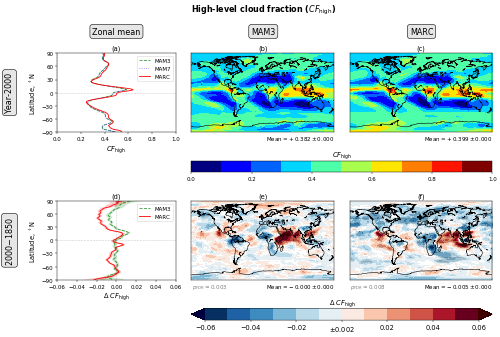

In [33]:
# High cloud fraction
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'CLDHGH', 'mam7': 'CLDHGH', 'marc': 'CLDHGH'},
                                 main_title=r'High-level cloud fraction ($CF_\mathrm{high}$)',
                                 xlabel=r'$CF_\mathrm{high}$', sf=None,
                                 xlim_2000=[0, 1], whiteout_2000=None, cmap_2000='jet', nlev_2000=10,
                                 xlim_diff=[-0.06, 0.06], whiteout_diff='0.002', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

### Precipitation and wind (supplement)

Mean = +1082.48±0.32
Mean = +1109.60±0.30
Mean = -6.13±0.52
Mean = -4.63±0.43
Written local/fS08.pdf


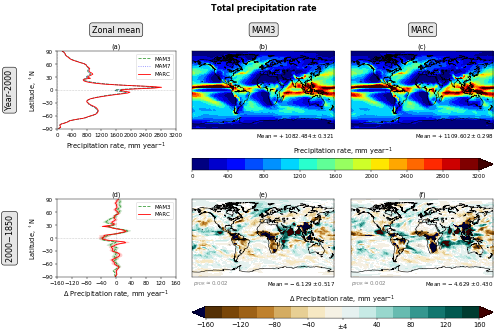

In [34]:
# Total precipitation rate
sf = 1e3*60*60*24*365  # m/s -> mm/year
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'cPRECT', 'mam7': 'cPRECT',
                                                 'marc': 'cPRECT'},
                                 main_title='Total precipitation rate',
                                 xlabel=r'Precipitation rate, mm year$^{-1}$', sf=sf,
                                 xlim_2000=[0, 3200], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-160, 160], whiteout_diff='4', cmap_diff='BrBG', nlev_diff=16,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +5.98±0.00
Mean = +6.02±0.00
Mean = -0.01±0.01
Mean = -0.02±0.00
Written local/fS09.pdf


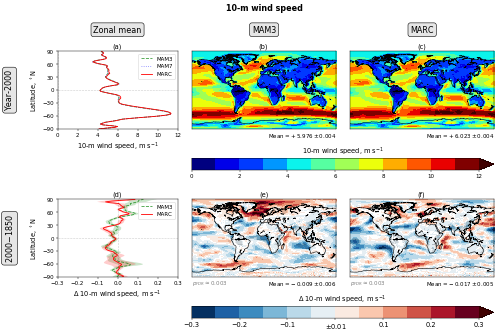

In [35]:
# 10-m wind speed
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'U10', 'mam7': 'U10',
                                                 'marc': 'U10'},
                                 main_title='10-m wind speed',
                                 xlabel=r'10-m wind speed, m s$^{-1}$', sf=None,
                                 xlim_2000=[0, 12], whiteout_2000=None, cmap_2000='jet', nlev_2000=12,
                                 xlim_diff=[-0.3, 0.3], whiteout_diff='0.01', cmap_diff='RdBu_r', nlev_diff=12,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

### Snow cover, snow rate, BC deposition, and BC in snow (supplement)

Mean = +0.10±0.00
Mean = +0.11±0.00


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +0.00±0.00


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +0.00±0.00
Written local/fS10.pdf


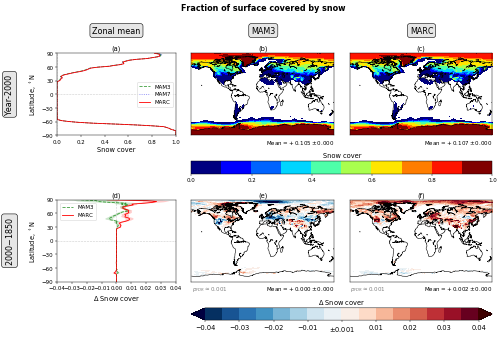

In [36]:
# Snow fractional cover
# Note: warnings arise due to calculation of p-values for locations with zero snow cover
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'cSnowCover', 'mam7': 'cSnowCover',
                                                 'marc': 'cSnowCover'},
                                 main_title='Fraction of surface covered by snow',
                                 xlabel='Snow cover', sf=None,
                                 xlim_2000=[0, 1], whiteout_2000=None, cmap_2000='jet', nlev_2000=10,
                                 xlim_diff=[-0.04, 0.04], whiteout_diff='0.001', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +81.99±0.15
Mean = +84.55±0.15
Mean = +1.29±0.22


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +1.62±0.23
Written local/fS11.pdf


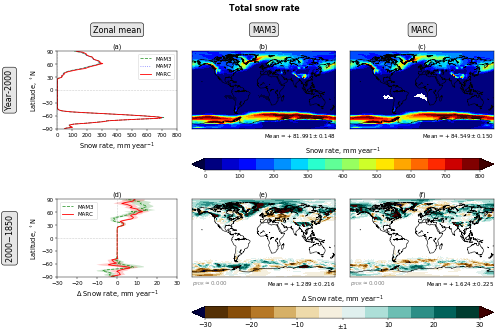

In [37]:
# Snow rate
sf = 1e3*60*60*24*365  # m/s -> mm/year (water equivalent)
# Note: warnings arise due to calculation of p-values for locations with snow rates of zero
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'cPRECST', 'mam7': 'cPRECST',
                                                 'marc': 'cPRECST'},
                                 main_title='Total snow rate',
                                 xlabel=r'Snow rate, mm year$^{-1}$', sf=sf,
                                 xlim_2000=[0, 800], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-30, 30], whiteout_diff='1', cmap_diff='BrBG', nlev_diff=12,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +11.67±0.01
Mean = +6.25±0.02


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +7.16±0.01


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +5.61±0.02
Written local/fS12.pdf


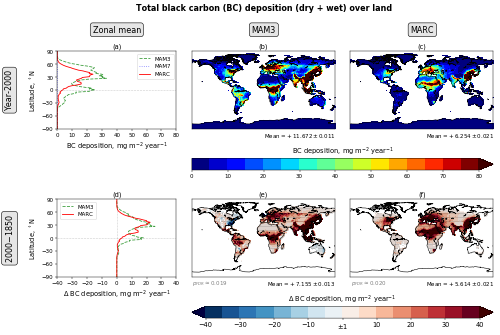

In [38]:
# BC deposition over land
sf = 1e6*60*60*24*365  # kg/m2/s -> mg/m2/year
# Note: ocean input set to zero (not missing)
# Note: warnings arise due to calculation of p-values for locations with values of zero (e.g. over ocean)
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'BCDEP', 'mam7': 'BCDEP', 'marc': 'BCDEP'},
                                 main_title='Total black carbon (BC) deposition (dry + wet) over land',
                                 xlabel=r'BC deposition, mg m$^{-2}$ year$^{-1}$',
                                 sf=sf,
                                 xlim_2000=[0, 80], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-40, 40], whiteout_diff='1', cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Mean = +0.01±0.00
Mean = +0.00±0.00


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +0.00±0.00


/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/grandey/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Mean = +0.00±0.00
Written local/fS13.pdf


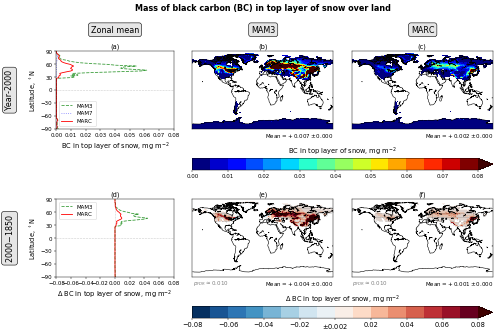

In [39]:
# Mass of BC in top layer of snow over land
sf = 1e6*60*60*24*365  # kg/m2/s -> mg/m2/year
# Note: ocean input set to zero (not missing)
# Note: warnings arise due to calculation of p-values for locations with values of zero (e.g. over ocean)
fig = zonal_means_maps_2000_diff(model_var_dict={'mam3': 'SNOBCMSL', 'mam7': 'SNOBCMSL',
                                                 'marc': 'SNOBCMSL'},
                                 main_title='Mass of black carbon (BC) in top layer of snow over land',
                                 xlabel=r'BC in top layer of snow, mg m$^{-2}$', sf=1e6,
                                 xlim_2000=[0, 0.08], whiteout_2000=None, cmap_2000='jet', nlev_2000=16,
                                 xlim_diff=[-0.08, 0.08], whiteout_diff='0.002',
                                 cmap_diff='RdBu_r', nlev_diff=16,
                                 file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

### Other figures

In [40]:
other_figure_counter = 1

Currently no other figures.

In [41]:
! date

Mon Nov 27 14:36:17 +08 2017
